#Text Mining project work
###Simeoni Ildebrando


The aim of this project is to further explore the possibilities of the descriptive text mining method presented in the previous project.

In this case the latent space for both words and documents has not been obtained via LSA, but rather by computing embeddings via transformers architectures; then, a similar approach to the previous notebook has been pursued, namely by exploiting visual inspection over the embedding space of terms and documents combined and by testing all the formulated hypotesis via chi-square tests.

##Utilities

###Libraries and installation
All the useful libraries and transformers requirments are installed

In [ ]:
!pip install -U sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 60.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 60.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 90.6 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=945d9532d3acb8601ed98713411d1c4349902c72db7ae37caa80a162c62b4d11
  Stored in directory: /root/.cache/pip/wheels/5e/6f/8c/d88aec621f3f542d26fac0342bef5e693335d125f4e54aeffe
Successfully built sentence-transformers


In [ ]:
import pandas as pd
import string
import re
from collections import Counter
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings("ignore")

###Utility functions
Here all the useful functions that will be later called in the notebook are defined.
A short informative description of each function preceeds its definition even if in most cases function names are self explanatory

In [ ]:
#Stoplist defined as the one used in the R notebook
stoplist = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'would', 'should', 'could', 'ought', "i'm", "you're", "he's", "she's", "it's", "we're", "they're", "i've", "you've", "we've", "they've", "i'd", "you'd", "he'd", "she'd", "we'd", "they'd", "i'll", "you'll", "he'll", "she'll", "we'll", "they'll", "isn't", "aren't", "wasn't", "weren't", "hasn't", "haven't", "hadn't", "doesn't", "don't", "didn't", "won't", "wouldn't", "shan't", "shouldn't", "can't", 'cannot', "couldn't", "mustn't", "let's", "that's", "who's", "what's", "here's", "there's", "when's", "where's", "why's", "how's", 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 'will']

In [ ]:
#Function that computes the unique values in a list
def unique(list1):
    unique_list = []
    for x in list1:
        if x not in unique_list:
            unique_list.append(x)
    return unique_list

#Function that, given a dataframe column of raw texts, creates a unified text corpus and performs normalization it; in the end it returns the list of obtained words
def corpus_creation(text_column):
  text = ''
  for i in text_column:
    text += ' '
    text += i
  print("Text before normalization:\n",text[0:200])
  #Punctuation removal
  new_text = text.translate(str.maketrans('', '', string.punctuation))
  #Lowercasing
  new_text = new_text.lower()
  #Removing stop words as in the R notebook
  new_text = new_text.split()
  resultwords  = [word for word in new_text if word not in stoplist]
  new_text = ' '.join(resultwords)
  print("Text after normalization:\n",new_text[0:200])
  #Splitting into words
  words = new_text.split()
  uniq_words = unique(words)
  print("Number of words before preprocessing:", len(uniq_words))
  #Removing numbers
  words = [x for x in words if not any(c.isdigit() for c in x)]
  #Removing sparse terms by keeping only the first 270
  words = [word for word, word_count in Counter(words).most_common(270)]
  print("Number of words after preprocessing:", len(words))
  return words

#Function that, given documents, performs their encoding via a specified transformer model
def sentence_embedding(model_name, sentences, class_column):
  model = SentenceTransformer(model_name)
  model.max_seq_length = 512
  sentences = list(sentences)
  #Sentences are encoded by calling model.encode() and then normalized
  sentence_embedded = model.encode(sentences, normalize_embeddings = True)
  print(sentence_embedded)
  #Dimensionality reduction of the 384 dimensional dense vector embeddings into a 50D representation via PCA for further dimensionality reduction
  X = list(sentence_embedded)
  X_PCA = PCA(n_components = 50).fit_transform(X)
  #Dimensionality reduction of the 50 dimensional dense vector embeddings into a 2D representation via TSNE for further visualization purposes
  X_embedded = TSNE(n_components=2).fit_transform(X_PCA)
  df_embeddings = pd.DataFrame(X_embedded)
  df_embeddings = df_embeddings.rename(columns={0:'x',1:'y'})
  accidents_list = list(class_column)
  df_embeddings['label'] = accidents_list
  #For visualization purposes
  df_embeddings['label'] = df_embeddings['label'].replace(['I','II','III','IV','V','VI'],[1,2,3,4,5,6])
  return(df_embeddings)

#Function that computes the same previous embedding but now on single words
def word_embedding(model_name, starting_words):
  model = SentenceTransformer(model_name)
  words = list(starting_words)
  word_embedded = model.encode(words, normalize_embeddings = True)

  X = list(word_embedded)
  X_PCA = PCA(n_components = 50).fit_transform(X)
  X_embedded = TSNE(n_components=2).fit_transform(X_PCA)
  df_embeddings = pd.DataFrame(X_embedded)
  df_embeddings = df_embeddings.rename(columns={0:'x',1:'y'})
  df_embeddings['label'] = starting_words
  return(df_embeddings)

#Function for visual inspection similar to the one defined in the R notebook
def visual_inspection(df_sentences, df_words, words):
  print('Graphic representations of the word embeddings \n')
  plt.figure(figsize=(15, 15))
  plt.scatter(x = df_words['x'], y = df_words['y'], color = 'none')
  for i, txt in enumerate(words):
      plt.annotate(txt, (df_words['x'][i], df_words['y'][i]))
  plt.show()
  print('Graphic representations of the document embeddings \n')
  plt.figure(figsize=(15, 15))
  plt.scatter( x = df_sentences['x'], y = df_sentences['y'], c = df_sentences[ 'label'], cmap = 'Set1')
  plt.show()
  print('Visual inspection with document and word embeddings in the same space \n')
  plt.figure(figsize=(20, 20))
  scatter = plt.scatter( x = df_sentences['x'], y = df_sentences['y'], c = df_sentences[ 'label'], cmap = 'Set1')
  plt.legend(*scatter.legend_elements())
  plt.scatter( x = df_words['x'], y = df_words['y'], color = 'none')
  for i, txt in enumerate(words):
      plt.annotate(txt, (df_words['x'][i], df_words['y'][i]))
  plt.show()

#Utility function that allows to easily find in the space the coordinates of some interesting words
def find_words(words_list, df_words):
  df_prova = df_words.loc[df_words['label'].isin(words_list)]
  plt.scatter(x = df_prova['x'], y = df_prova['y'], color = 'red')

#Function that computes the syntactic correlation between a word and a accident class as the one defined in the R notebook
def test_a_word(text_column, word, class_):
  documents = list(text_column)
  # Create the CountVectorizer object
  vectorizer = CountVectorizer()
  # Fit and transform the documents
  tdm = vectorizer.fit_transform(documents)
  # Create a boolean vector indicating which documents contain the word
  has_word = (tdm[:,vectorizer.vocabulary_[word]] > 0).toarray().flatten()
  # Create a boolean vector indicating which documents belong to the class
  is_class = df.apply(lambda x: x["Potential Accident Level"] == class_, axis=1)
  # Create a contingency table of the variables has_word and is_class
  word_vs_class = pd.crosstab(has_word, is_class)
  word_vs_class.index = ["No", "Yes"]
  word_vs_class.columns = ["No", "Yes"]
  # Perform the chi-squared test
  chisqtest, pvalue, _, _ = chi2_contingency(word_vs_class, correction=False)
  print("The chi-square test has a p-value of: ", pvalue)
  if (pvalue < 0.05):
    print(f'So the word {word} and the class {class_} are correlated')
  else:
    print(f'So the word {word} and the class {class_} are not correlated')

##Code

###Dataset creation
In this section the same dataset used for the project is loaded and manipulated.

Dataset manipulation has been kept as similar as possible to the one performed in the project notebook in order to ensure results reproducibility

In [ ]:
filename = '/content/IHMStefanini_industrial_safety_and_health_database_with_accidents_description.csv'
starting_df = pd.read_csv(filename)
print(len(starting_df))
starting_df.head(3)

425


,Unnamed: 0,Data,Countries,Local,Industry Sector,Accident Level,Potential Accident Level,Genre,Employee or Third Party,Critical Risk,Description
0,0,2016-01-01 00:00:00,Country_01,Local_01,Mining,I,IV,Male,Third Party,Pressed,While removing the drill rod of the Jumbo 08 f...
1,1,2016-01-02 00:00:00,Country_02,Local_02,Mining,I,IV,Male,Employee,Pressurized Systems,During the activation of a sodium sulphide pum...
2,2,2016-01-06 00:00:00,Country_01,Local_03,Mining,I,III,Male,Third Party (Remote),Manual Tools,In the sub-station MILPO located at level +170...


In [ ]:
df = starting_df[['Description', 'Potential Accident Level']]
df = df.drop_duplicates(subset=['Description'])
print(len(df))
df.head(3)

411


,Description,Potential Accident Level
0,While removing the drill rod of the Jumbo 08 f...,IV
1,During the activation of a sodium sulphide pum...,IV
2,In the sub-station MILPO located at level +170...,III


In [ ]:
accidents = df['Potential Accident Level']
descriptions =  df['Description']

In [ ]:
words = corpus_creation(descriptions)

Text before normalization:
  While removing the drill rod of the Jumbo 08 for maintenance, the supervisor proceeds to loosen the support of the intermediate centralizer to facilitate the removal, seeing this the mechanic support
Text after normalization:
 removing drill rod jumbo 08 maintenance supervisor proceeds loosen support intermediate centralizer facilitate removal seeing mechanic supports one end drill equipment pull hands bar accelerate remova
Number of words before preprocessing: 3432
Number of words after preprocessing: 270


###Embeddings
In this group of cells the embeddings of both documents and words are performed. Rather than computing them via LSA now a sentence transformer has been used

In this notebook two are the most important changes applied to the project notebook:
* SentenceTransformers
* Dimensionality reduction via PCA and T-SNE

**SentenceTransformers** is a Python framework for state-of-the-art sentence, text and image embeddings. The initial work is described in the paper *Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks*.

This framework, chosen because of the simplicity with which embeddings can be computed, can be used to compute sentence / text embeddings for more than 100 languages which can then be compared e.g. with cosine-similarity to find sentences with a similar meaning. This can be useful for semantic textual similar, semantic search, or paraphrase mining.

The framework is based on PyTorch and Transformers and offers a large collection of pre-trained models tuned for various tasks, in particular
*all-MiniLM-L6-v2* (https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2) as a sentence-transformers model has been selected. It maps sentences & paragraphs to a 384 dimensional dense vector space and can be used for tasks like clustering or semantic search.

Our model is intented to be used as a sentence and short paragraph encoder. Given an input text, it ouptuts a vector which captures the semantic information. The sentence vector may be used for information retrieval, clustering or sentence similarity tasks.

**Dimensionality reduction** was required in order to obtain a 2D representation of both word and document embeddings, in order to plot them, starting from the 384 dimensional dense vector representation obtained from the aforementioned sentence transformer.

A variety of methods to achieve this dimensionality reduction are present, but, insipred by the literature a two step approach combining PCA and T-SNE has been selected.

T-SNE (T-distributed Stochastic Neighbor Embedding) is a tool to visualize high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data.

What it does in simple terms is to create vectors in a 2-dimensional space, such that if two vectors have small distance in the N-dimensional space, they also have small distance in the 2-dimensional space. We obtain from that a 2-dimensional plot, which offers a little insight into how transformer embeddings are distributed.

Being highly recommended to use another dimensionality reduction method (e.g. PCA for dense data or TruncatedSVD for sparse data) to reduce the number of dimensions to a reasonable amount (e.g. 50) if the number of features is very high, this approach has been tackled also in the notebook, by firstly reducing the 384D embedding output of the sentence transformer into a 50D array via PCA and then feeding it to the T-SNE.

This will suppress some noise and speed up the computation of pairwise distances between samples.

In [ ]:
df_words = word_embedding('all-MiniLM-L6-v2', words)
df_words.head()

,x,y,label
0,15.753813,-2.499812,causing
1,-2.586395,-17.246946,hand
2,-14.385433,-1.256916,left
3,9.488081,0.509143,right
4,-10.855238,14.728172,employee


In [ ]:
df_sentences = sentence_embedding ('all-MiniLM-L6-v2', descriptions, accidents)
df_sentences.head()

,x,y,label
0,-2.413715,-2.993776,4
1,18.891563,-0.587946,4
2,-4.911214,7.900500,3
3,-5.205281,-0.677342,1
4,8.228150,4.597401,4


###Visual inspection
In this section the same visual inspection performed in the project notebook is here revived, in particular both document and word embeddings computed by the transformer are shown



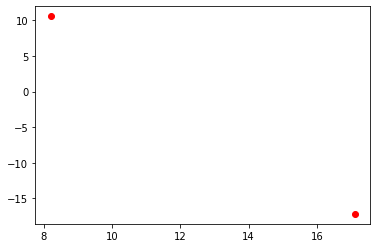

In [ ]:
find_words(['drilling', 'falling'], df_words)

Graphic representations of the word embeddings 



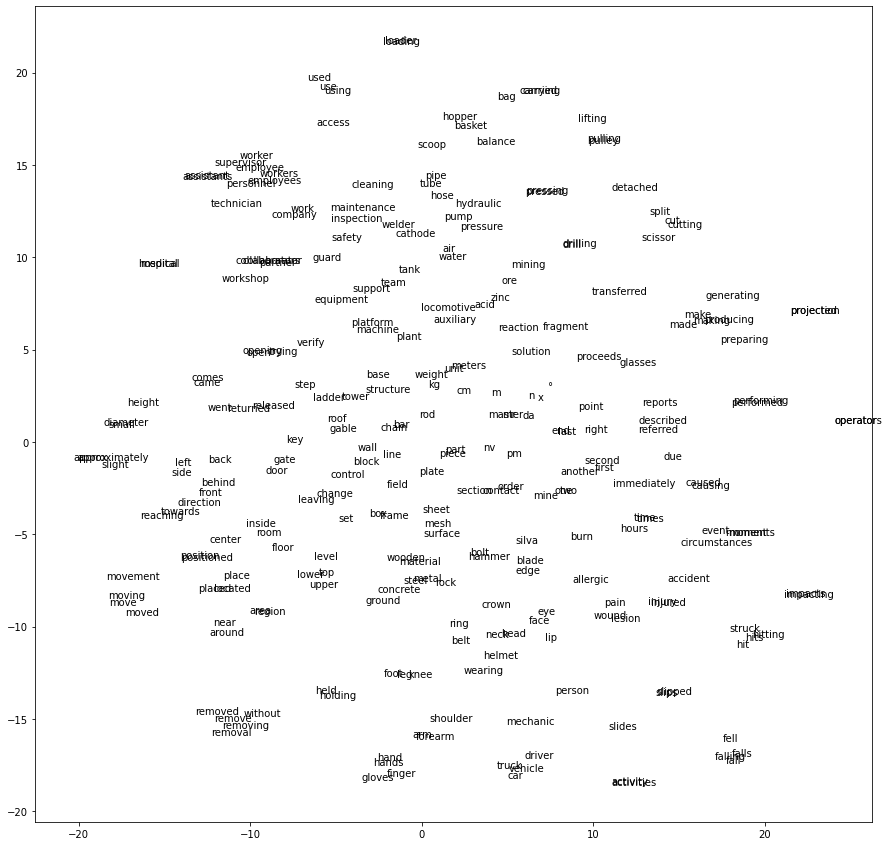

Graphic representations of the document embeddings 



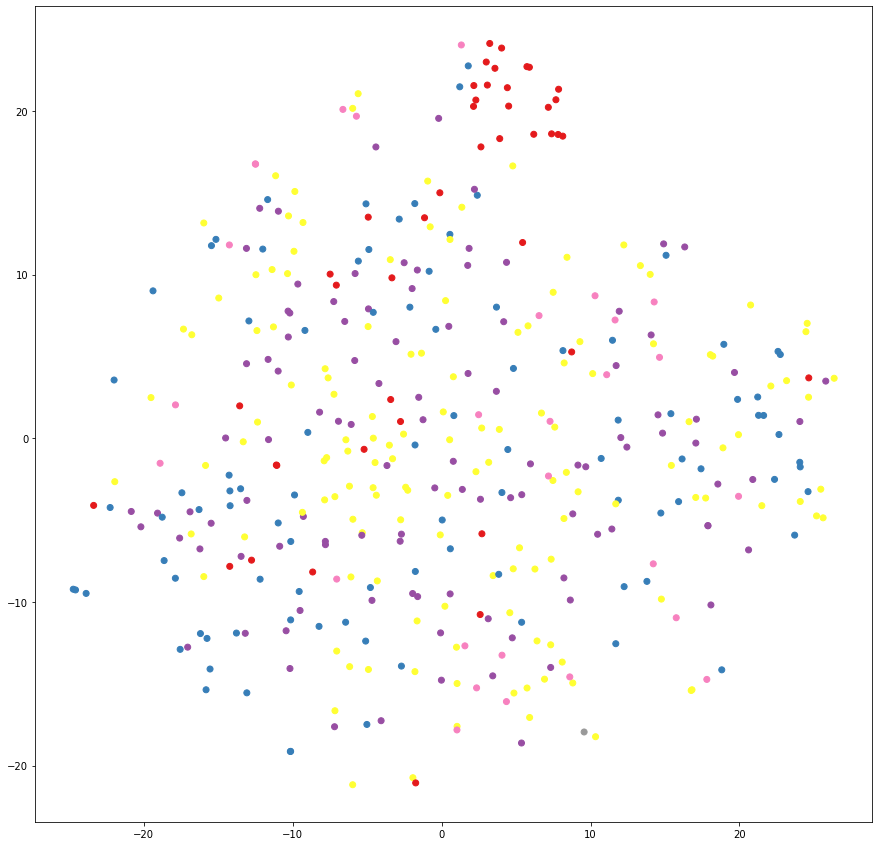

Visual inspection with document and word embeddings in the same space 



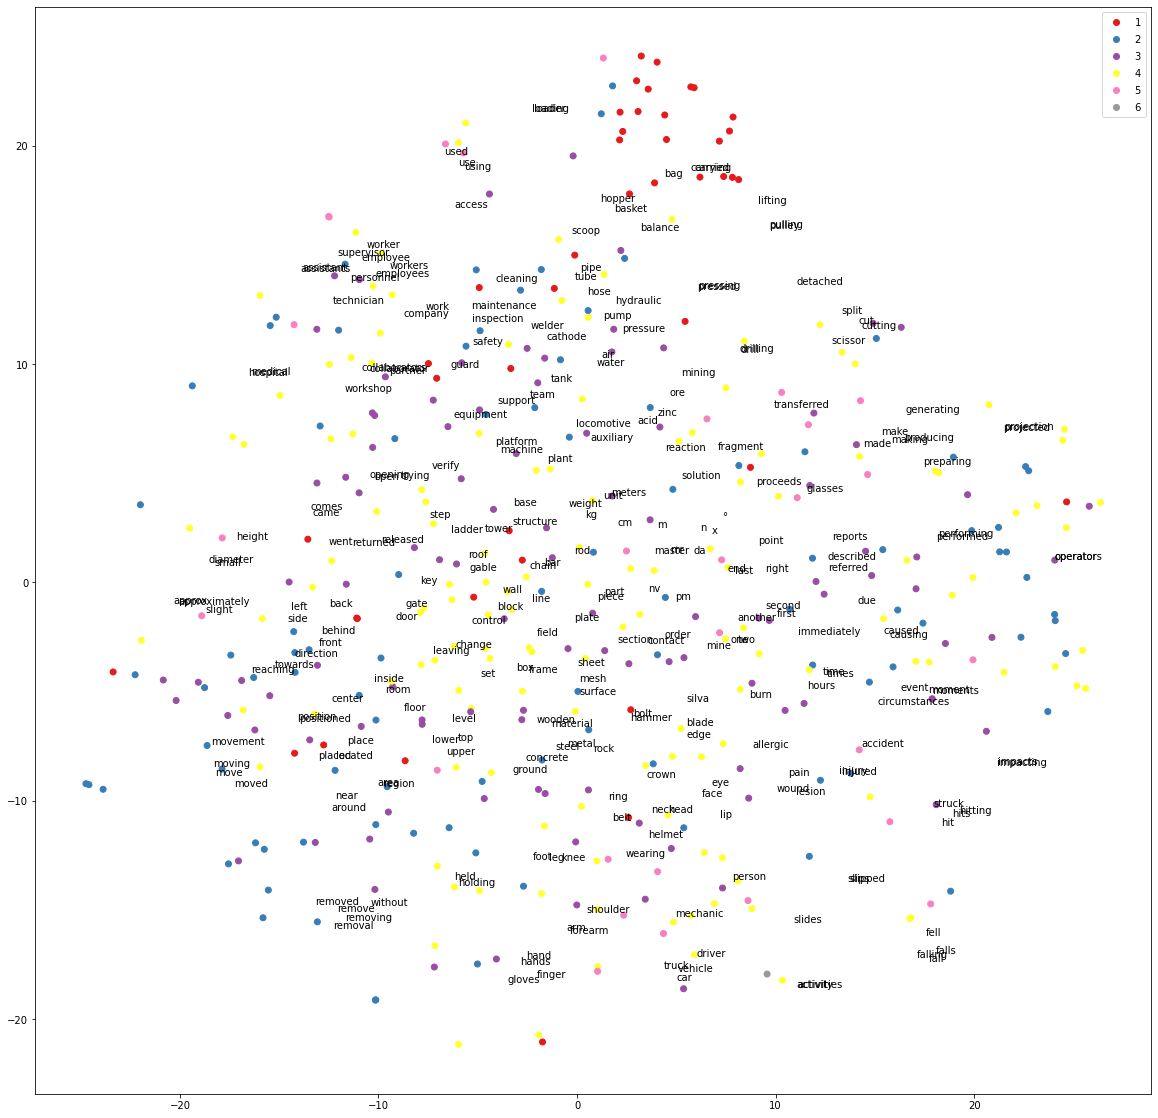

In [ ]:
visual_inspection(df_sentences, df_words, words)

##Conclusion
In this last section:
*   a comparison of the embedding results, obtained via LSA and via sentence transformer, is shown
*   a visual analysis on previous analysis directions and on possible new ones is performed

Successive steps are the same as the ones performed in the project notebook, the aim of this notebook was to highlight the differences up to the visual analysis of the two considered approaches

###Comparison

####Text

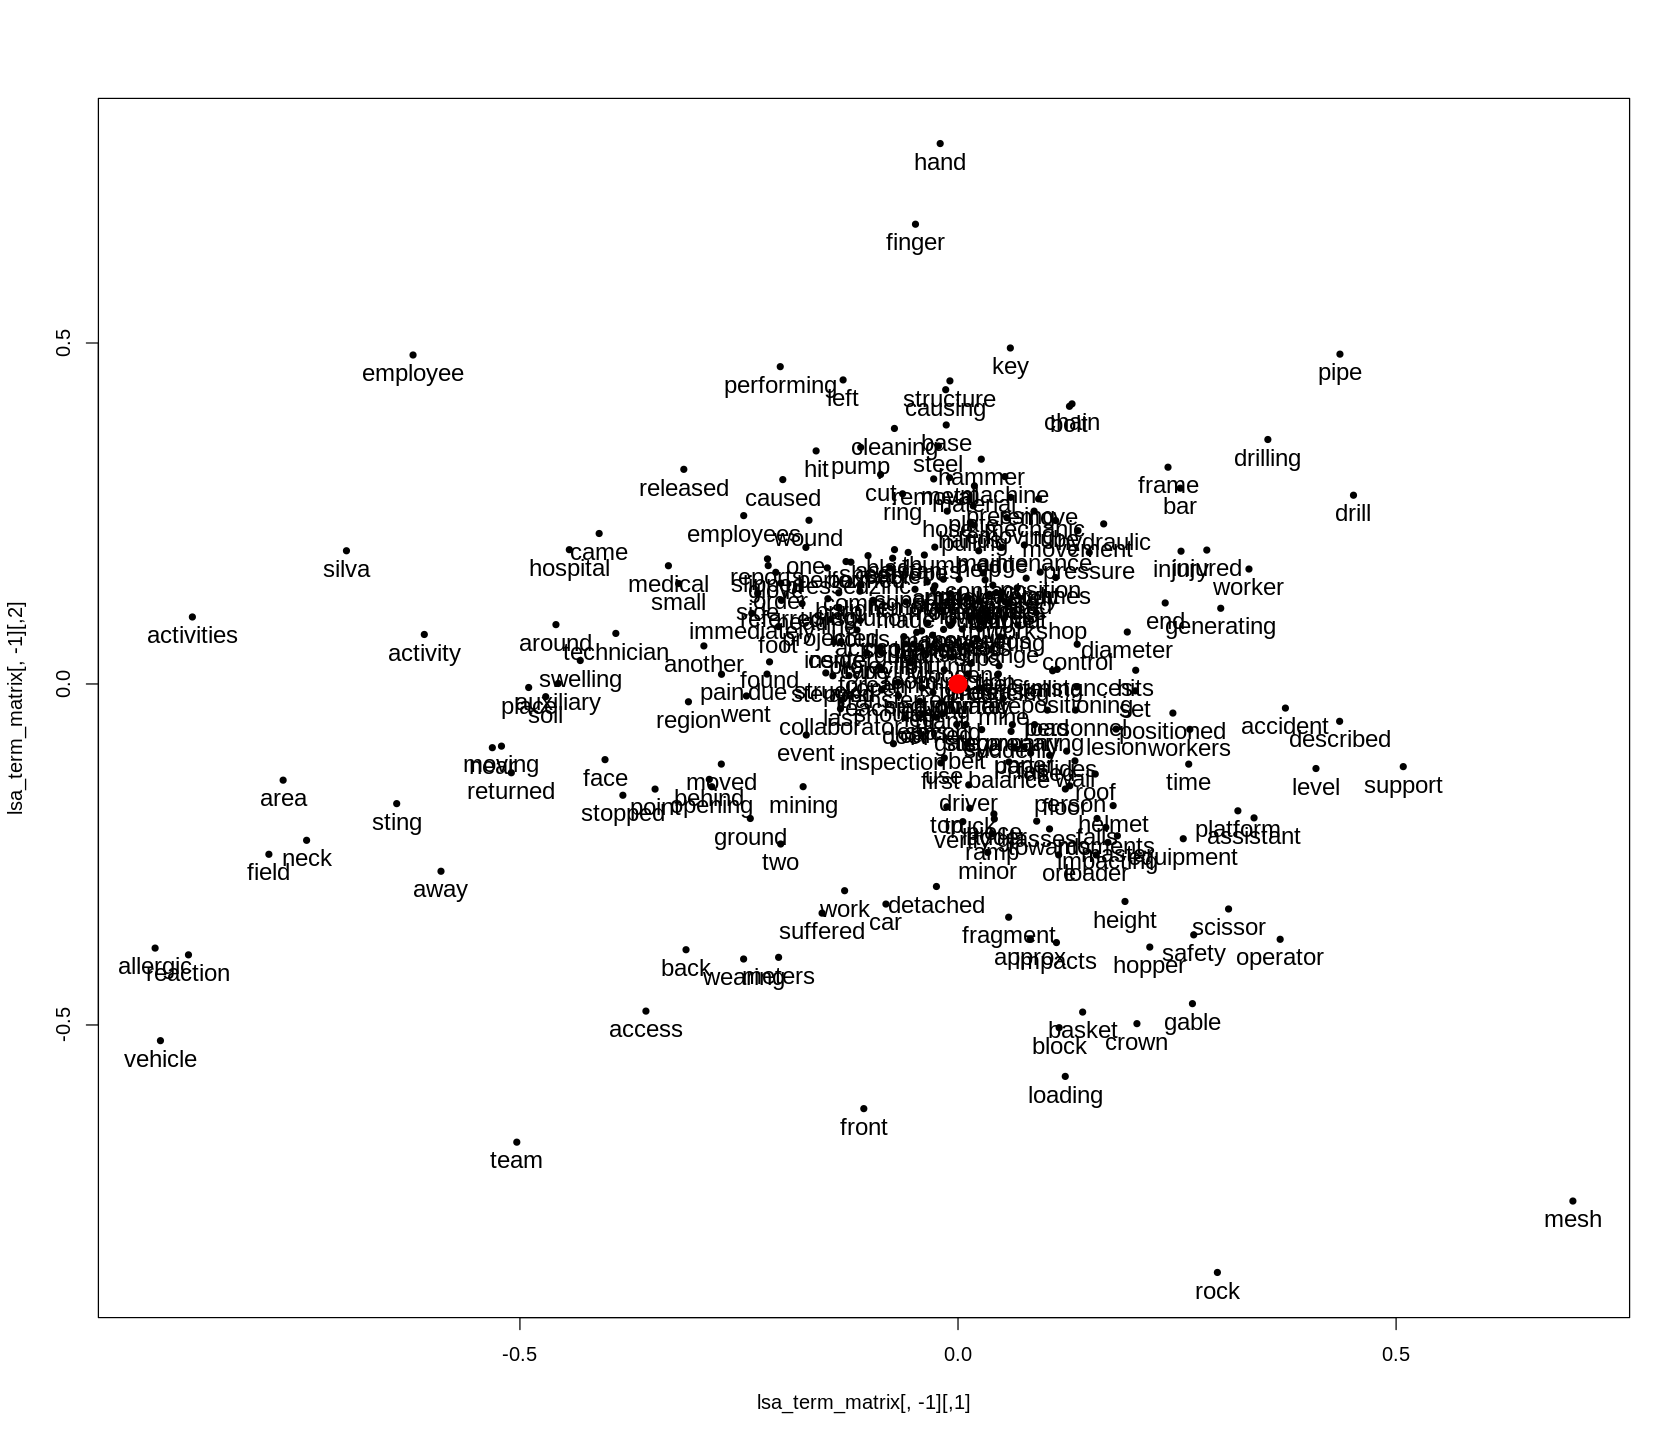

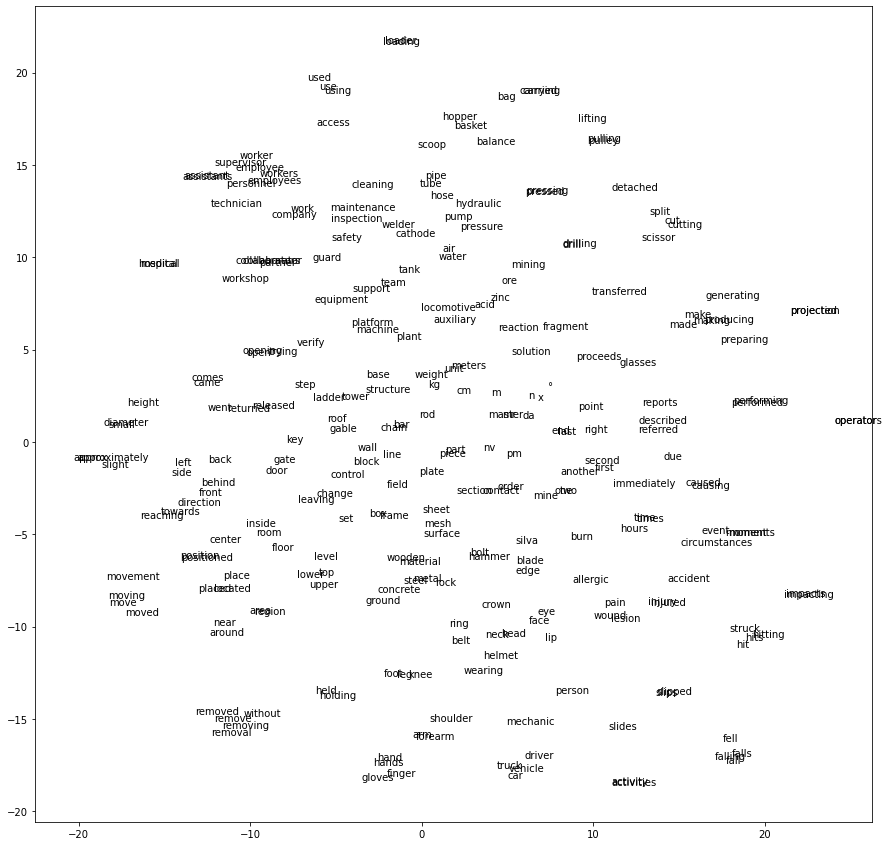

In the above comparison word embeddings obtained by LSA and by transformers are respectively shown.

Some insights that can be inferred from the comparison are:
* in the second graph we can see how words are way less concentrated in the origin, and much more spread apart
* the semantic similarity among group of words is more evident in the second graph, where synonyms are way more clustered and separated from other words than in the first one
* in the second graph well defined clusters of similar words can be spotted, namely: body parts and related protective equipment, similar meaning verbs and variations, unit measures, job types, work equipment
* in both cases most interesting words are located far away from the origin of the graph (this will be a decisive factor in the choice of the following analysis directions)


####Documents

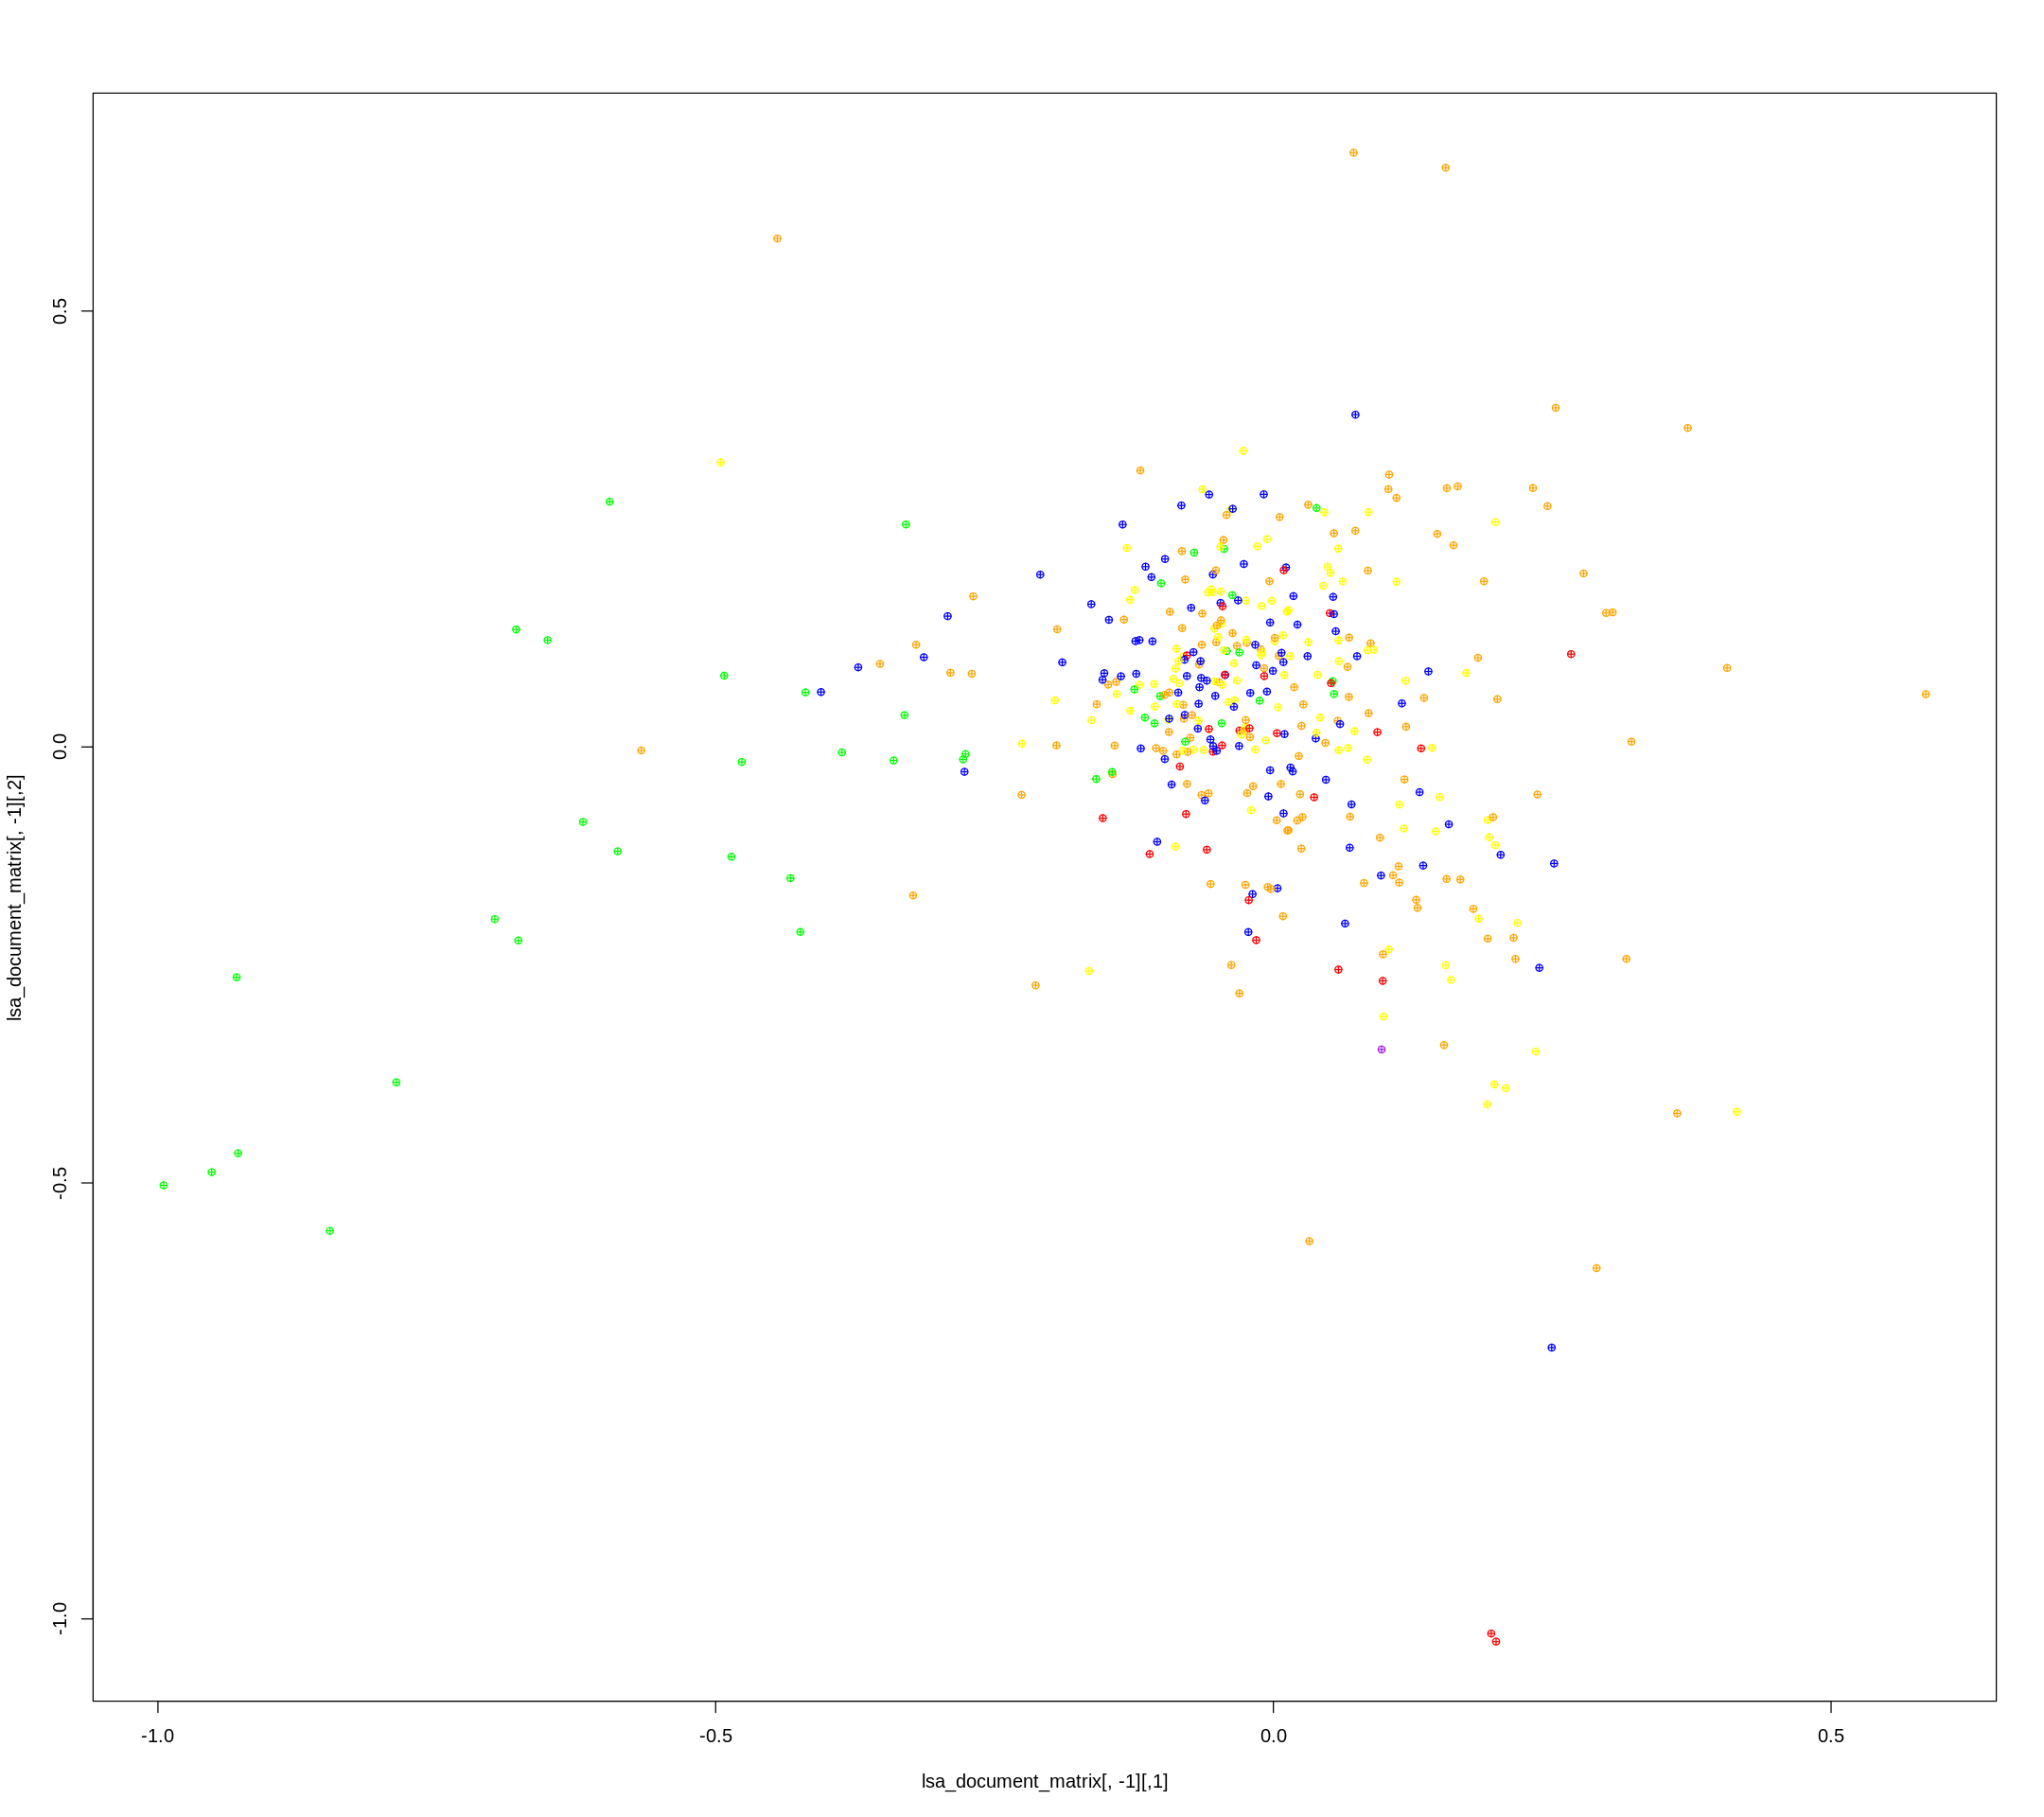

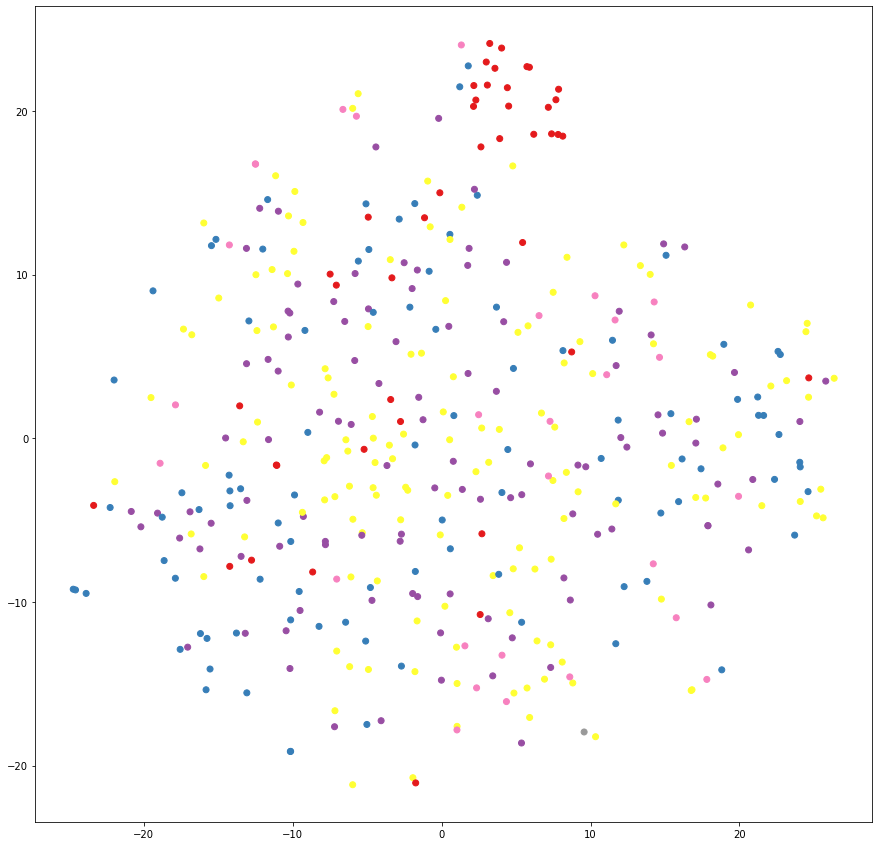

In the above comparison document embeddings obtained by LSA and by transformers are respectively shown.

Remember that the color code for accident severity differs in the two graph, namely:
* R graph (i.e. project graph): green I, blue II, yellow III, orange IV, red V, purple VI
* Python graph (i.e. project work graph): red I, blue II, violet III, yellow IV, pink V, grey VI

Some insights that can be inferred from the comparison are:
* in both cases the highest density in the graph can be spotted around the origin, even if that's even more evident in the project graph
* in the project work graph a more radial distribution is obtained with respect to the project one, this can slightly complicate the process of finding interesting direction analysis which differ from the expected distribution
* in both cases documents related to harmless accidents (i.e. level I) are the easiest one to cluster and separate from the majority of documents, this is particularly true in the project work graph
* a more clear separation of similar accidents level documents is obtained in the project graph, where level III and level IV documents are less mixed, especially in zones far away from the origin


####Analysis directions

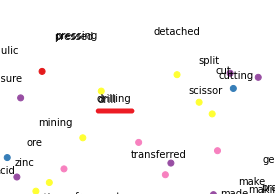

As shown in the visual inspection phase, also with those embeddings the term **drilling** and relative synonyms are located in a zone of particular interest in terms of type IV accident distribution.

Also in this case we should perform a Chi-square test to confirm our intuition. The obtained result is the same as the one in the project notebook, confirming our theory that **drilling** as a term and IV accidents are correlated

In [ ]:
test_a_word(descriptions,'drilling', 'IV')

The chi-square test has a p-value of:  4.88976664957179e-05
So the word drilling and the class IV are correlated


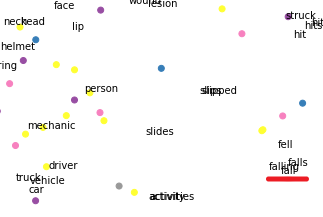

Other than confirming our estabilished theories, this new reorganized space allowed also to infer some new hypotesis, useful to define new analysis directions.

For example, in this case the term **falling** and all its synonyms appear concentrated in a space region far away from the center, dense of documents related to high severity accidents; this hypotesis deserves to be further explored via a Chi-square test

In [ ]:
test_a_word(descriptions,'falling', 'IV')

The chi-square test has a p-value of:  0.021545184617276125
So the word falling and the class IV are correlated
